# GUMDPs: The impact of the number of trials

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math
import itertools

import seaborn as sns
sns.set_style("dark")

matplotlib.rcParams['text.usetex'] =  True
plt.rc('text.latex', preamble=r'\usepackage{pifont} \usepackage{amsfonts}')
matplotlib.rcParams.update({'font.size': 16})

sns.set_palette("colorblind")

#### Auxiliary functions

In [2]:
def compute_d_pi(mdp, policy):
    # Args:
    # mdp - MDP specification.
    # policy - policy specification (np.array).

    nS = len(mdp["states"])
    nA = len(mdp["actions"])

    P_pi = np.zeros((nS, nS))
    
    for a in range(nA):
        P_pi += np.dot(np.diag(policy[:,a]), mdp["P"][a])

    d_S = (1 - mdp["gamma"]) * np.dot(mdp["p_0"], np.linalg.inv(np.eye(nS) - mdp["gamma"] * P_pi))
    d_pi = np.dot(np.diag(d_S), policy)
    
    return d_pi

In [3]:
def sample_trajectory(mdp, policy, traj_length):
    # Args:
    # mdp - MDP specification.
    # policy - policy specification (np.array).
    # traj_length - length of the sampled trajectory.

    states = []
    actions = []

    s = np.random.choice(mdp["states"], p=mdp["p_0"])

    for t in range(traj_length):
        states.append(s)

        a = np.random.choice(mdp["actions"], p=policy[s])
        actions.append(a)

        s =  np.random.choice(mdp["states"], p=mdp["P"][a,s,:])

    return states, actions

In [4]:
def estimate_d_pi_from_trajectory(mdp, trajectory_states, trajectory_actions):
    # Args:
    # mdp - MDP specification.
    # trajectory_states - list with sampled states.
    # trajectory_actions - list with sampled actions.
    
    nS = len(mdp["states"])
    nA = len(mdp["actions"])

    d_hats = []
    d_hat = np.zeros((nS,nA))
    for t in range(len(trajectory_states)):
        s_t = trajectory_states[t]
        a_t = trajectory_actions[t]
        
        d_hat[s_t,a_t] += mdp["gamma"]**t * 1

        d_hats.append(((1 - mdp["gamma"])/(1 - mdp["gamma"]**(t+1))) * d_hat)
        
    return np.array(d_hats)

In [5]:
def estimate_f_d_pi_from_samples(mdp, policy, N, K, max_traj_length):
    # Args:
    # mdp - MDP specification.
    # policy - policy specification (np.array).
    # N - number of times K trajectories are sampled.
    # K - number of trajectories to sample.
    # max_traj_length - the maximum length of each sampled trajectory.

    nS = len(mdp["states"])
    nA = len(mdp["actions"])

    f_estimated_list = []
    for n in range(N):

        # Compute d_hat from K sampled trajectories.
        d_hat = np.zeros((max_traj_length,nS,nA))
        for k in range(K):
            traj_states, traj_actions = sample_trajectory(mdp, policy, traj_length=max_traj_length)
            d_hat += estimate_d_pi_from_trajectory(mdp, traj_states, traj_actions)
        d_hat = d_hat / K

        # Compute f(d_hat).
        d_hat_flattened = d_hat.reshape((max_traj_length,-1)) # [max_traj_length, nS, nA]
        f_d_hat = np.array([mdp["f"](x) for x in d_hat_flattened])

        f_estimated_list.append(f_d_hat)

    return np.array(f_estimated_list) # [N, max_traj_length]

In [6]:
def mean_ci(samples: np.ndarray, num_resamples: int=25_000):
    # Point estimation.
    point_estimate = np.mean(samples)
    # Confidence interval estimation.
    resampled = np.random.choice(samples,
                                size=(len(samples), num_resamples),
                                replace=True)
    point_estimations = np.mean(resampled, axis=0)
    confidence_interval = [np.percentile(point_estimations, 5),
                           np.percentile(point_estimations, 95)]
    return confidence_interval

In [7]:
GLOBAL_DATA_ESTIMATED = {}
GLOBAL_DATA_TRUE = {}

## Entropy maximization

#### $f(d_\pi) = -d_\pi^\top \log(d_\pi)$

In [8]:
# Define MDP (taken from https://arxiv.org/pdf/2202.01511.pdf - Fig. 3 (a))
mdp = {}
mdp["states"] = [0,1,2]
mdp["actions"] = [0,1] # Action 0 = left, action 1 = right
mdp["gamma"] = 0.5
mdp["p_0"] = [1.0,0.0,0.0]
mdp["P"] = np.array([[[0,1,0],[0,1,0],[1,0,0]],[[0,0,1],[1,0,0],[0,0,1]]])
mdp["f"] = lambda x: np.dot(x, np.log(x + 1e-07))

In [9]:
policy_1 = np.array([[0.5,0.5], [0.0,1.0], [1.0,0.0]])

#### Compute $f_\infty(\pi) =  f(d_\pi)$

In [10]:
d_pi_1 = compute_d_pi(mdp, policy_1)
print("f(d_\pi) =", mdp["f"](d_pi_1.flatten()))

f(d_\pi) = -1.329660948854848


#### Compute $f_{K,H}(\pi) = \mathbb{E}_{\mathcal{T}_K } \left[ f\left(\hat{d}_{\mathcal{T}_K, H} \right) \right]$

In [11]:
f_estimated = estimate_f_d_pi_from_samples(mdp, policy_1, N=2, K=5, max_traj_length=20)
print(f_estimated.shape)

(2, 20)


#### Compare $f(d_\pi)$ and $ f\left(\hat{d}_{\mathcal{T}_K, H} \right)$ for multiple $K$ and $\gamma$ values

In [12]:
gammas = [0.2,0.4,0.6,0.8,0.99]
max_traj_length = 500 # this is more than enough to approximate H = \infty.
N_val = 100
k_vals = [1,2,5,10]

# Compute f(d_hats).
estimated_fs_dict = {}
for gamma_val in gammas:
    print("gamma=", gamma_val)
    mdp["gamma"] = gamma_val
    estimated_fs_dict_aux = {}
    for k_val in k_vals:
        print("k_val:", k_val)
        estimated_fs_dict_aux[k_val] = estimate_f_d_pi_from_samples(mdp, policy_1, N=N_val, K=k_val, max_traj_length=max_traj_length) # [N, max_traj_lengt

    estimated_fs_dict[gamma_val] = estimated_fs_dict_aux

# Compute f(d_pis)
true_fs_dict = {}
for gamma_val in gammas:
    print("gamma=", gamma_val)
    mdp["gamma"] = gamma_val
    d_pi_1 = compute_d_pi(mdp, policy_1)
    true_fs_dict[gamma_val] = mdp["f"](d_pi_1.flatten())

gamma= 0.2
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.4
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.6
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.8
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.99
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.2
gamma= 0.4
gamma= 0.6
gamma= 0.8
gamma= 0.99


In [13]:
print(estimated_fs_dict.keys())
print(estimated_fs_dict[0.2].keys())
print(estimated_fs_dict[0.2][1].shape)

dict_keys([0.2, 0.4, 0.6, 0.8, 0.99])
dict_keys([1, 2, 5, 10])
(100, 500)


In [14]:
GLOBAL_DATA_ESTIMATED["entropy"] = estimated_fs_dict
GLOBAL_DATA_TRUE["entropy"] = true_fs_dict

(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)


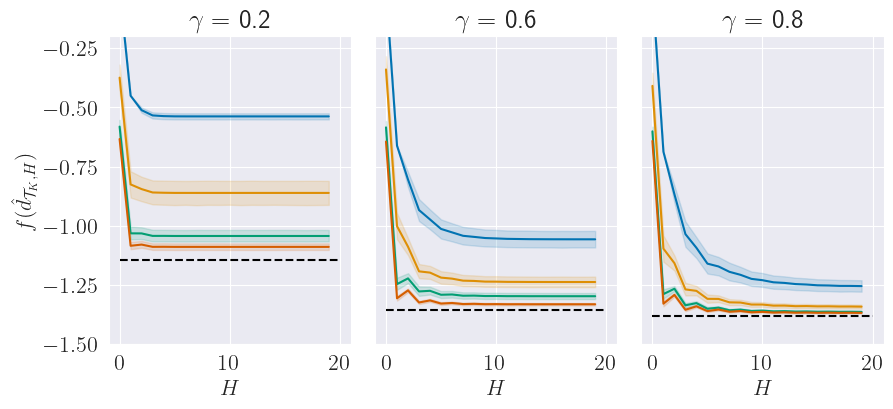

In [15]:
fig, axs = plt.subplots(1, 3, gridspec_kw = {'wspace':0.1, 'hspace':0})
fig.set_size_inches(10.0, 4.0)
#fig.tight_layout()

truncate_traj_length = 20

for gamma_val, ax in zip([0.2,0.6,0.8], axs.flat):

    for k_val, estimated_fs in estimated_fs_dict[gamma_val].items():

        estimated_fs = estimated_fs[:,:truncate_traj_length]
        
        p = ax.plot(np.arange(estimated_fs.shape[1]), np.mean(estimated_fs, axis=0), label=r'$K=$ ' + str(k_val))
    
        cis = [mean_ci(estimated_fs[:,idx]) for idx in range(estimated_fs.shape[1])]
        cis = np.array(cis)
        print(cis.shape)
        ax.fill_between(np.arange(estimated_fs.shape[1]), cis[:,0], cis[:,1],
                            color=p[0].get_color(), alpha=0.15)

    ax.hlines(y=true_fs_dict[gamma_val], xmin=0, xmax=estimated_fs.shape[1], label=r"$f(d_\pi)$", color="black", linestyle="--")

    ax.grid()
    
    ax.set_ylim([-1.5,-0.2])
    ax.set_title(r"$\gamma = $ " + str(gamma_val))
    ax.set_xlabel(r'$H$')

# Remove inner labels.
for ax in fig.get_axes():
    ax.label_outer()

axs.flat[0].set_ylabel(r'$f(\hat{d}_{\mathcal{T}_K,H})$')

plt.savefig(f'figs/entropy_mdp_plot1.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

#### Compare $f(d_\pi)$ and $ f\left(\hat{d}_{\mathcal{T}_K, H} \right)$ for multiple $K$ and $\gamma$ values when $H=\infty$

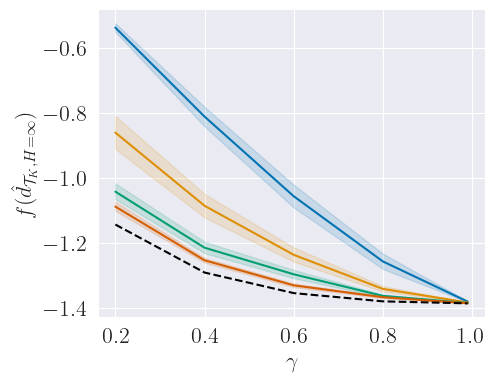

In [16]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

for k_val in k_vals:

    ys = []
    upper_cis = []
    lower_cis = []
    
    for gamma_val in gammas:
        ys.append(np.mean(estimated_fs_dict[gamma_val][k_val][:,-1]))

        cis = mean_ci(estimated_fs_dict[gamma_val][k_val][:,-1])
        cis = np.array(cis)
        lower_cis.append(cis[0])
        upper_cis.append(cis[1])

    p = plt.plot(gammas, ys, label=rf"$K={k_val}$")
    plt.fill_between(gammas, lower_cis, upper_cis,
                            color=p[0].get_color(), alpha=0.15)

true_fs = [true_fs_dict[gamma] for gamma in gammas]

plt.plot(gammas, true_fs, label=r"$f(d_\pi)$", color="black", linestyle="--")

plt.xlabel(r'$\gamma$')
plt.ylabel(r'$f(\hat{d}_{\mathcal{T}_K,H=\infty})$')
plt.grid()
#plt.legend() #(loc=1)

plt.savefig(f'figs/entropy_mdp_plot2.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [17]:
# Put a legend below the current axis.
"""legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.17),
        fancybox=True, shadow=True, ncol=4)

# Export only legend.
legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=5)
def export_legend(legend, filename="legend.pdf"):
    fig  = legend.figure
    fig.canvas.draw()
    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(filename, dpi="figure", bbox_inches=bbox)
export_legend(legend)"""

'legend = plt.legend(loc=\'upper center\', bbox_to_anchor=(0.5, -0.17),\n        fancybox=True, shadow=True, ncol=4)\n\n# Export only legend.\nlegend = plt.legend(loc=\'upper center\', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=5)\ndef export_legend(legend, filename="legend.pdf"):\n    fig  = legend.figure\n    fig.canvas.draw()\n    bbox  = legend.get_window_extent().transformed(fig.dpi_scale_trans.inverted())\n    fig.savefig(filename, dpi="figure", bbox_inches=bbox)\nexport_legend(legend)'

## Imitation learning

#### $f(d_\pi) = KL(d_\pi | d_\beta)$

In [15]:
# Define MDP (taken from https://arxiv.org/pdf/2202.01511.pdf - Fig. 3 (c))
mdp = {}
mdp["states"] = [0,1]
mdp["actions"] = [0,1] # Action 0 = left, action 1 = right
mdp["gamma"] = 0.5
mdp["p_0"] = [1.0,0.0]
mdp["P"] = np.array([[[1.0,0.0],[1.0,0.0]],[[0.0,1.0],[0.0,1.0]]])

In [16]:
# Define policy.
policy = np.array([[0.6,0.4], [0.3,0.7]])

# Define behavior policy.
beta = np.array([[0.5,0.5], [0.5,0.5]])

# Define objective function.
d_beta = compute_d_pi(mdp, beta).flatten()
mdp["f"] = lambda x: np.sum(x * np.log((x / (d_beta + 1e-07)) + 1e-07 ))

#### Compute $f_\infty(\pi) =  f(d_\pi)$

In [17]:
d_pi = compute_d_pi(mdp, policy)
print("f(d_\pi) =", mdp["f"](d_pi.flatten()))

f(d_\pi) = 0.035342638375965074


#### Compute $\mathcal{F}_{K,H}(\pi) = \mathbb{E}_{\mathcal{T}_K } \left[ f\left(\hat{d}_{\mathcal{T}_K, H} \right) \right]$

In [18]:
f_estimated = estimate_f_d_pi_from_samples(mdp, policy, N=2, K=5, max_traj_length=20)
print(f_estimated.shape)
print(f_estimated)

(2, 20)
[[0.48042664 0.25075488 0.23058715 0.19107106 0.16343015 0.16765937
  0.1652491  0.1662923  0.16555389 0.1651018  0.16487717 0.16485088
  0.16477168 0.16472558 0.16472556 0.16471939 0.16471526 0.16471465
  0.16471428 0.16471388]
 [0.48042664 0.4263646  0.34127355 0.26724566 0.24304046 0.24264459
  0.23754066 0.23650011 0.23559431 0.23428154 0.23399862 0.23397621
  0.23387722 0.23386862 0.2338583  0.23385485 0.23385463 0.23385515
  0.23385383 0.23385329]]


#### Compare $f(d_\pi)$ and $ f\left(\hat{d}_{\mathcal{T}_K, H} \right)$ for multiple $K$ and $\gamma$ values

In [19]:
gammas = [0.2,0.4,0.6,0.8,0.99]
max_traj_length = 500 # this is more than enough to approximate H = \infty.
N_val = 100
k_vals = [1,2,5,10]

# Compute f(d_hats).
estimated_fs_dict = {}
for gamma_val in gammas:
    print("gamma=", gamma_val)
    mdp["gamma"] = gamma_val
    
    # Define objective function (since gamma changed d_beta changes).
    d_beta = compute_d_pi(mdp, beta).flatten()
    mdp["f"] = lambda x: np.sum(x * np.log((x / (d_beta + 1e-07)) + 1e-07 ))
    
    estimated_fs_dict_aux = {}
    for k_val in k_vals:
        print("k_val:", k_val)
        estimated_fs_dict_aux[k_val] = estimate_f_d_pi_from_samples(mdp, policy, N=N_val, K=k_val, max_traj_length=max_traj_length) # [N, max_traj_lengt

    estimated_fs_dict[gamma_val] = estimated_fs_dict_aux

# Compute f(d_pis)
true_fs_dict = {}
for gamma_val in gammas:
    print("gamma=", gamma_val)
    mdp["gamma"] = gamma_val

    # Define objective function (since gamma changed d_beta changes).
    d_beta = compute_d_pi(mdp, beta).flatten()
    mdp["f"] = lambda x: np.sum(x * np.log((x / (d_beta + 1e-07)) + 1e-07 ))
    
    d_pi_1 = compute_d_pi(mdp, policy)
    true_fs_dict[gamma_val] = mdp["f"](d_pi_1.flatten())

gamma= 0.2
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.4
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.6
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.8
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.99
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.2
gamma= 0.4
gamma= 0.6
gamma= 0.8
gamma= 0.99


In [22]:
print(estimated_fs_dict.keys())
print(estimated_fs_dict[0.2].keys())
print(estimated_fs_dict[0.2][1].shape)

dict_keys([0.2, 0.4, 0.6, 0.8, 0.99])
dict_keys([1, 2, 5, 10])
(100, 500)


In [23]:
GLOBAL_DATA_ESTIMATED["imitation"] = estimated_fs_dict
GLOBAL_DATA_TRUE["imitation"] = true_fs_dict

(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)


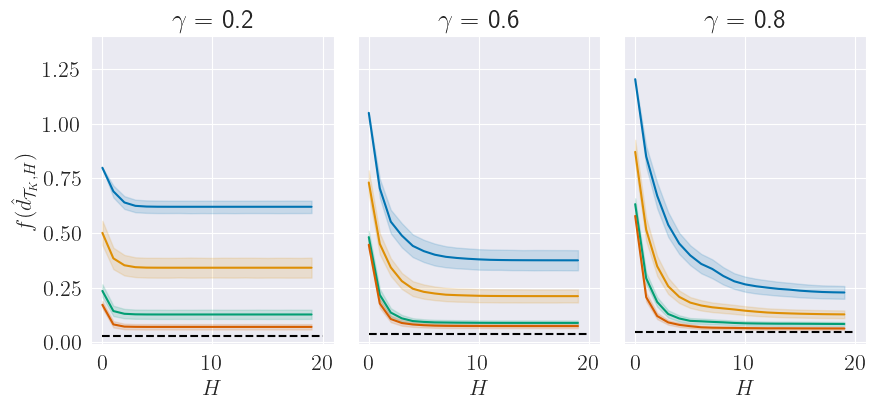

In [26]:
fig, axs = plt.subplots(1, 3, gridspec_kw = {'wspace':0.1, 'hspace':0})
fig.set_size_inches(10.0, 4.0)
#fig.tight_layout()

truncate_traj_length = 20

for gamma_val, ax in zip([0.2,0.6,0.8], axs.flat):

    for k_val, estimated_fs in estimated_fs_dict[gamma_val].items():

        estimated_fs = estimated_fs[:,:truncate_traj_length]

        p = ax.plot(np.arange(estimated_fs.shape[1]), np.mean(estimated_fs, axis=0), label=r'$K=$ ' + str(k_val))
    
        cis = [mean_ci(estimated_fs[:,idx]) for idx in range(estimated_fs.shape[1])]
        cis = np.array(cis)
        print(cis.shape)
        ax.fill_between(np.arange(estimated_fs.shape[1]), cis[:,0], cis[:,1],
                            color=p[0].get_color(), alpha=0.15)

    ax.hlines(y=true_fs_dict[gamma_val], xmin=0, xmax=estimated_fs.shape[1], label=r"$f(d_\pi)$", color="black", linestyle="--")

    ax.grid()
    
    ax.set_ylim([-0.01,1.4])
    ax.set_title(r"$\gamma = $ " + str(gamma_val))
    ax.set_xlabel(r'$H$')

# Remove inner labels.
for ax in fig.get_axes():
    ax.label_outer()

axs.flat[0].set_ylabel(r'$f(\hat{d}_{\mathcal{T}_K,H})$')

plt.savefig(f'figs/imitation_mdp_plot1.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

#### Compare $f(d_\pi)$ and $ f\left(\hat{d}_{\mathcal{T}_K, H} \right)$ for multiple $K$ and $\gamma$ values when $H=\infty$

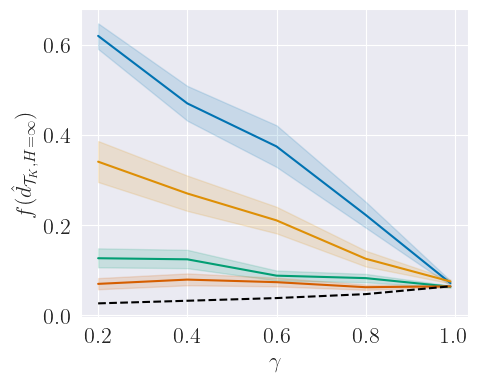

In [27]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

for k_val in k_vals:

    ys = []
    upper_cis = []
    lower_cis = []
    
    for gamma_val in gammas:
        ys.append(np.mean(estimated_fs_dict[gamma_val][k_val][:,-1]))

        cis = mean_ci(estimated_fs_dict[gamma_val][k_val][:,-1])
        cis = np.array(cis)
        lower_cis.append(cis[0])
        upper_cis.append(cis[1])

    p = plt.plot(gammas, ys, label=rf"$K={k_val}$")
    plt.fill_between(gammas, lower_cis, upper_cis,
                            color=p[0].get_color(), alpha=0.15)

true_fs = [true_fs_dict[gamma] for gamma in gammas]

plt.plot(gammas, true_fs, label=r"$f(d_\pi)$", color="black", linestyle="--")

plt.xlabel(r'$\gamma$')
plt.ylabel(r'$f(\hat{d}_{\mathcal{T}_K,H=\infty})$')
plt.grid()
#plt.legend() #(loc=1)

plt.savefig(f'figs/imitation_mdp_plot2.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## Quadratic minimization

In [24]:
# Define MDP.
mdp = {}
mdp["states"] = [0,1,2]
mdp["actions"] = [0,1] # Action 0 = up, action 1 = down
mdp["gamma"] = 0.5
mdp["p_0"] = [1.0,0.0,0.0]
mdp["P"] = np.array([[[0,1,0],[0,1,0],[0,0,1]],[[0,0,1],[0,1,0],[0,0,1]]])

def obj(d):
    d_s1 = d[2] + d[3] # d(s_1) = d(s_1,a_0) + d(s_1,a_1)
    d_s2 = d[4] + d[5] # d(s_2) = d(s_2,a_0) + d(s_2,a_1)
    return 1*d_s1**2 + 0.5*d_s2**2
mdp["f"] = obj

In [25]:
# Define policy.
policy = np.array([[0.5,0.5], [0.5,0.5], [0.5,0.5]])

#### Compute $f_\infty(\pi) =  f(d_\pi)$

In [26]:
d_pi = compute_d_pi(mdp, policy)
print("f(d_\pi) =", mdp["f"](d_pi.flatten()))

f(d_\pi) = 0.09375


#### Compare $f(d_\pi)$ and $ f\left(\hat{d}_{\mathcal{T}_K, H} \right)$ for multiple $K$ and $\gamma$ values

In [27]:
f_estimated = estimate_f_d_pi_from_samples(mdp, policy, N=2, K=5, max_traj_length=20)
print(f_estimated.shape)
print(f_estimated)

(2, 20)
[[0.         0.03777778 0.06244898 0.07404444 0.07960458 0.082323
  0.08366669 0.08433464 0.08466764 0.0848339  0.08491697 0.08495849
  0.08497925 0.08498962 0.08499481 0.08499741 0.0849987  0.08499935
  0.08499968 0.08499984]
 [0.         0.03777778 0.06244898 0.07404444 0.07960458 0.082323
  0.08366669 0.08433464 0.08466764 0.0848339  0.08491697 0.08495849
  0.08497925 0.08498962 0.08499481 0.08499741 0.0849987  0.08499935
  0.08499968 0.08499984]]


#### Compare $f(d_\pi)$ and $ f\left(\hat{d}_{\mathcal{T}_K, H} \right)$ for multiple $K$ and $\gamma$ values

In [28]:
gammas = [0.2,0.4,0.6,0.8,0.99]
max_traj_length = 500 # this is more than enough to approximate H = \infty.
N_val = 100
k_vals = [1,2,5,10]

# Compute f(d_hats).
estimated_fs_dict = {}
for gamma_val in gammas:
    print("gamma=", gamma_val)
    mdp["gamma"] = gamma_val
    estimated_fs_dict_aux = {}
    for k_val in k_vals:
        print("k_val:", k_val)
        estimated_fs_dict_aux[k_val] = estimate_f_d_pi_from_samples(mdp, policy, N=N_val, K=k_val, max_traj_length=max_traj_length) # [N, max_traj_lengt

    estimated_fs_dict[gamma_val] = estimated_fs_dict_aux

# Compute f(d_pis)
true_fs_dict = {}
for gamma_val in gammas:
    print("gamma=", gamma_val)
    mdp["gamma"] = gamma_val
    d_pi_1 = compute_d_pi(mdp, policy)
    true_fs_dict[gamma_val] = mdp["f"](d_pi_1.flatten())

gamma= 0.2
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.4
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.6
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.8
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.99
k_val: 1
k_val: 2
k_val: 5
k_val: 10
gamma= 0.2
gamma= 0.4
gamma= 0.6
gamma= 0.8
gamma= 0.99


In [29]:
print(estimated_fs_dict.keys())
print(estimated_fs_dict[0.2].keys())
print(estimated_fs_dict[0.2][1].shape)

dict_keys([0.2, 0.4, 0.6, 0.8, 0.99])
dict_keys([1, 2, 5, 10])
(100, 500)


In [30]:
GLOBAL_DATA_ESTIMATED["quadratic"] = estimated_fs_dict
GLOBAL_DATA_TRUE["quadratic"] = true_fs_dict

(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)


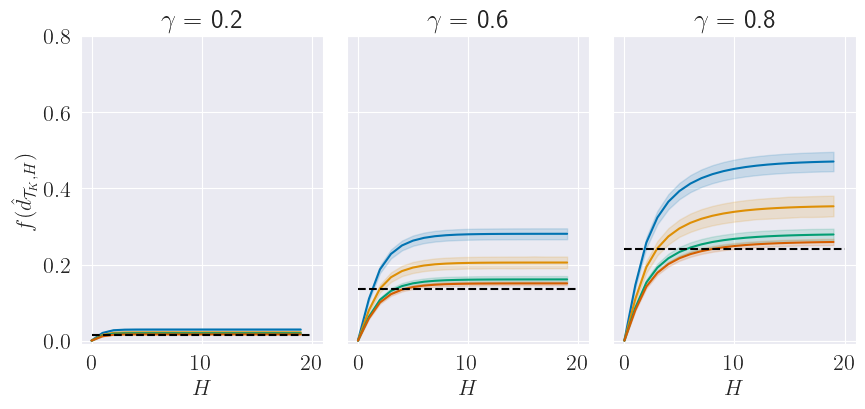

In [36]:
fig, axs = plt.subplots(1, 3, gridspec_kw = {'wspace':0.1, 'hspace':0})
fig.set_size_inches(10.0, 4.0)
#fig.tight_layout()

truncate_traj_length = 20

for gamma_val, ax in zip([0.2,0.6,0.8], axs.flat):

    for k_val, estimated_fs in estimated_fs_dict[gamma_val].items():

        estimated_fs = estimated_fs[:,:truncate_traj_length]
        
        p = ax.plot(np.arange(estimated_fs.shape[1]), np.mean(estimated_fs, axis=0), label=r'$K=$ ' + str(k_val))
    
        cis = [mean_ci(estimated_fs[:,idx]) for idx in range(estimated_fs.shape[1])]
        cis = np.array(cis)
        print(cis.shape)
        ax.fill_between(np.arange(estimated_fs.shape[1]), cis[:,0], cis[:,1],
                            color=p[0].get_color(), alpha=0.15)

    ax.hlines(y=true_fs_dict[gamma_val], xmin=0, xmax=estimated_fs.shape[1], label=r"$f(d_\pi)$", color="black", linestyle="--")

    ax.grid()
    
    ax.set_ylim([-0.01,0.8])
    ax.set_title(r"$\gamma = $ " + str(gamma_val))
    ax.set_xlabel(r'$H$')

# Remove inner labels.
for ax in fig.get_axes():
    ax.label_outer()

axs.flat[0].set_ylabel(r'$f(\hat{d}_{\mathcal{T}_K,H})$')

plt.savefig(f'figs/quadratic_mdp_plot1.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

#### Compare $f(d_\pi)$ and $ f\left(\hat{d}_{\mathcal{T}_K, H} \right)$ for multiple $K$ and $\gamma$ values when $H=\infty$

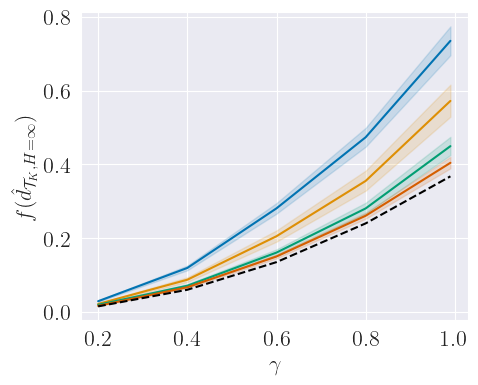

In [37]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

for k_val in k_vals:

    ys = []
    upper_cis = []
    lower_cis = []
    
    for gamma_val in gammas:
        ys.append(np.mean(estimated_fs_dict[gamma_val][k_val][:,-1]))

        cis = mean_ci(estimated_fs_dict[gamma_val][k_val][:,-1])
        cis = np.array(cis)
        lower_cis.append(cis[0])
        upper_cis.append(cis[1])

    p = plt.plot(gammas, ys, label=rf"$K={k_val}$")
    plt.fill_between(gammas, lower_cis, upper_cis,
                            color=p[0].get_color(), alpha=0.15)

true_fs = [true_fs_dict[gamma] for gamma in gammas]

plt.plot(gammas, true_fs, label=r"$f(d_\pi)$", color="black", linestyle="--")

plt.xlabel(r'$\gamma$')
plt.ylabel(r'$f(\hat{d}_{\mathcal{T}_K,H=\infty})$')
plt.grid()
#plt.legend() #(loc=1)

plt.savefig(f'figs/quadratic_mdp_plot2.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## Merged plot

In [31]:
print(GLOBAL_DATA_ESTIMATED.keys())
print(GLOBAL_DATA_TRUE.keys())

dict_keys(['entropy', 'imitation', 'quadratic'])
dict_keys(['entropy', 'imitation', 'quadratic'])


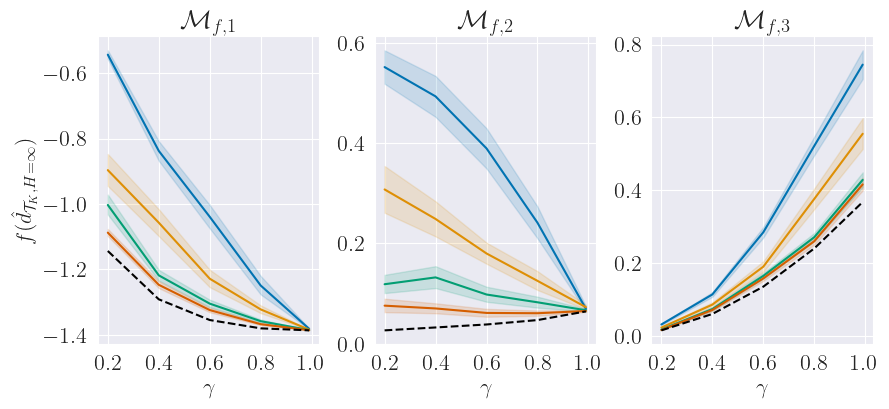

In [34]:
fig, axs = plt.subplots(1, 3, gridspec_kw = {'wspace':0.25, 'hspace':0})
fig.set_size_inches(10.0, 4.0)
#fig.tight_layout()

titles = {'entropy': r'$\mathcal{M}_{f,1}$', 'imitation': r'$\mathcal{M}_{f,2}$', 'quadratic': r'$\mathcal{M}_{f,3}$'}

for ax, (mdp_type, estimated_fs_dict) in zip(axs.flat, GLOBAL_DATA_ESTIMATED.items()):
    
    for k_val in k_vals:
    
        ys = []
        upper_cis = []
        lower_cis = []
        
        for gamma_val in gammas:
            ys.append(np.mean(estimated_fs_dict[gamma_val][k_val][:,-1]))
    
            cis = mean_ci(estimated_fs_dict[gamma_val][k_val][:,-1])
            cis = np.array(cis)
            lower_cis.append(cis[0])
            upper_cis.append(cis[1])
    
        p = ax.plot(gammas, ys, label=rf"$K={k_val}$")
        ax.fill_between(gammas, lower_cis, upper_cis,
                                color=p[0].get_color(), alpha=0.15)
    
    true_fs = [GLOBAL_DATA_TRUE[mdp_type][gamma] for gamma in gammas]
    
    ax.plot(gammas, true_fs, label=r"$f(d_\pi)$", color="black", linestyle="--")

    ax.grid()
    ax.set_xlabel(r'$\gamma$')
    ax.set_xticks([0.2,0.4,0.6,0.8,1.0])
    ax.set_title(titles[mdp_type])

axs.flat[0].set_ylabel(r'$f(\hat{d}_{\mathcal{T}_K,H=\infty})$')

plt.savefig(f'figs/gammas_merged_plot.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

# Visualizing different GU-MDPs objectives

In [7]:
def cartesian(arrays, out=None):
    """
    Generate a Cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the Cartesian product of.
    out : ndarray
        Array to place the Cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing Cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    #m = n / arrays[0].size
    m = int(n / arrays[0].size)
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
        #for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out

In [8]:
def f_K(x, K, f):
    aux_list = [[0,1]]*K
    act_combinations = cartesian(aux_list)

    out = 0.0
    for comb in act_combinations:
        num_a_0 = (K-np.sum(comb))
        num_a_1 = np.sum(comb)
        out += f( (1.0/K) * num_a_0 ) * x**(num_a_0) * (1-x)**(num_a_1)

    return out

### Quadratic minimization

In [9]:
def f_quadratic(x, a=1.0, b=0.5):
    return a*x**2 + b*(1-x)**2

Argmin f(d_pi): 0.3333333333333333
Argmin f(d_K), K=1: 0.0
Argmin f(d_K), K=2: 0.16616616616616617
Argmin f(d_K), K=4: 0.2772772772772773
Argmin f(d_K), K=8: 0.30930930930930933


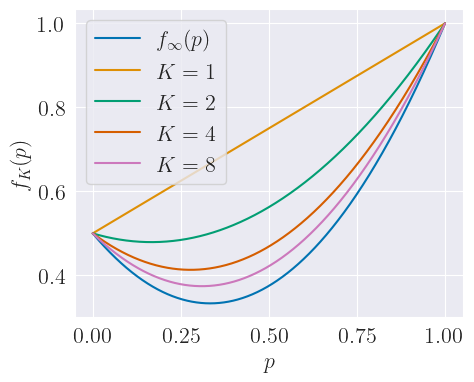

In [10]:
Ks = [1,2,4,8] #,10]

fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

x = np.linspace(0,1,1_000)

ys = f_quadratic(x)
plt.plot(x, ys, label=r"$f_\infty(p)$")
print("Argmin f(d_pi):", x[np.argmin(ys)])

for k in Ks:
    ys = f_K(x,K=k,f=f_quadratic)
    plt.plot(x, ys, label=rf"$K={k}$")
    print(f"Argmin f(d_K), K={k}:", x[np.argmin(ys)])

plt.xlabel(r'$p$')
plt.ylabel(r'$f_K(p)$')
plt.grid()
plt.legend() #(loc=1)
#plt.ylim(-0.2, 0.4)

plt.savefig('quadratic_minimization_func.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

### Entropy maximization

In [35]:
def f_entropy(x, a=1.0, b=0.01):
    return a*x*np.log(x + 1e-07) + b*(1-x)*np.log(1-x + 1e-07)

Argmin f(d_pi): 0.36936936936936937
Argmin f(d_K), K=1: 0.0
Argmin f(d_K), K=2: 0.4994994994994995
Argmin f(d_K), K=4: 0.44144144144144143
Argmin f(d_K), K=8: 0.4014014014014014


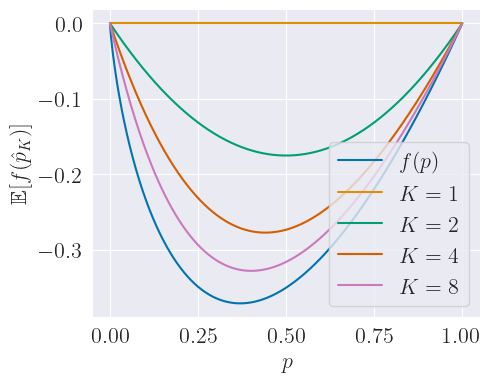

In [37]:
Ks = [1,2,4,8] #,10]

fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

x = np.linspace(0.0,1.0,1_000)

ys = f_entropy(x)
plt.plot(x, ys, label=r"$f(p)$")
print("Argmin f(d_pi):", x[np.argmin(ys)])

for k in Ks:
    ys = f_K(x,K=k,f=f_entropy)
    plt.plot(x, ys, label=rf"$K={k}$")
    print(f"Argmin f(d_K), K={k}:", x[np.argmin(ys)])

plt.xlabel(r'$p$')
plt.ylabel(r'$\mathbb{E}[f(\hat{p}_K)]$')
plt.grid()
plt.legend() #(loc=1)
#plt.ylim(-0.2, 0.4)

#plt.savefig('MC_bound_plot.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

### Linear

In [50]:
def f_linear(x, a=1.0, b=0.5):
    return a*x + b*(1-x)

Argmin f(d_pi): 0.0
Argmin f(d_K), K=1: 0.0
Argmin f(d_K), K=2: 0.0
Argmin f(d_K), K=4: 0.0
Argmin f(d_K), K=8: 0.0


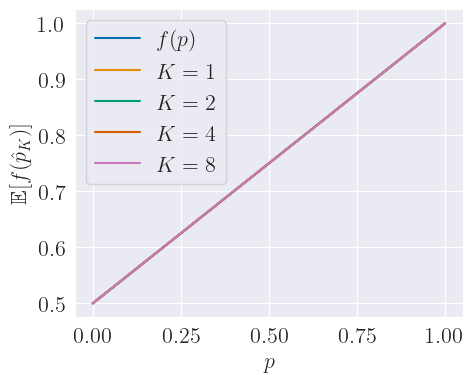

In [51]:
Ks = [1,2,4,8] #,10]

fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

x = np.linspace(0,1,1_000)

ys = f_linear(x)
plt.plot(x, ys, label=r"$f(p)$")
print("Argmin f(d_pi):", x[np.argmin(ys)])

for k in Ks:
    ys = f_K(x,K=k,f=f_linear)
    plt.plot(x, ys, label=rf"$K={k}$")
    print(f"Argmin f(d_K), K={k}:", x[np.argmin(ys)])

plt.xlabel(r'$p$')
plt.ylabel(r'$\mathbb{E}[f(\hat{p}_K)]$')
plt.grid()
plt.legend() #(loc=1)
#plt.ylim(-0.2, 0.4)

#plt.savefig('MC_bound_plot.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

#### Deprecated

In [65]:
# Inequality test
num_samples = 10_000
Ks = [1,2,4,8,10]

ps = np.linspace(0.0,1.0,10)
ys = {}

for k in Ks:

    ys[k] = []
    
    for p in ps:
        samples = np.random.binomial(n=k,p=p,size=num_samples)
        entropies = (samples/k)*np.log(samples/k + 1e-07) + (1-(samples/k)) * np.log(1-(samples/k) + 1e-07)
        ys[k].append(np.mean(entropies))

print(ps)
print(ys)

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
{1: [9.999999505838704e-08, 9.999999505838704e-08, 9.999999505838704e-08, 9.999999505838704e-08, 9.999999505838704e-08, 9.999999505838704e-08, 9.999999505838704e-08, 9.999999505838704e-08, 9.999999505838704e-08, 9.999999505838704e-08], 2: [9.999999505838704e-08, -0.13495563658502926, -0.2415616575751512, -0.3101139038425313, -0.34560303436720125, -0.34296907546107336, -0.31150019800365114, -0.23705620155151147, -0.13842137198782908, 9.999999505838704e-08], 4: [9.999999505838704e-08, -0.2225311522982626, -0.3763469426632355, -0.482565007819317, -0.5348543033907983, -0.5341319702165185, -0.47929126836048747, -0.37305277475042503, -0.21713393429333158, 9.999999505838704e-08], 8: [9.999999505838704e-08, -0.2744625697447005, -0.45458913849371013, -0.5661373417694143, -0.6183828911185002, -0.6202824574817124, -0.5669183907101307, -0.4590197119102962, -0.27490640414257017, 9.999999

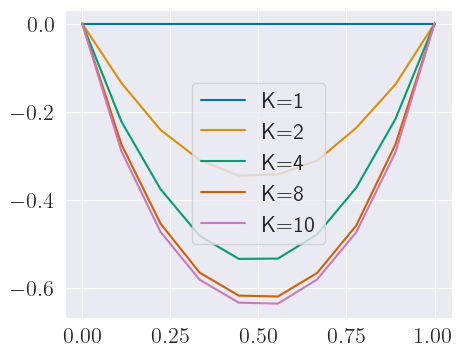

In [66]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

for k in Ks:
    plt.plot(ps, ys[k], label=f"K={k}")

#plt.xlabel(r'$p$')
#plt.ylabel(r'$\mathbb{E}[f(\hat{p}_K)]$')
plt.grid()
plt.legend() #(loc=1)

plt.show()

In [99]:
# Inequality test
num_samples = 10_000
Ks = [1,2,4,8]

ps = np.linspace(0.0,1.0,100)
ys = {}

for k in Ks:
    print("k=", k)

    ys[k] = []
    
    for p in ps:
        samples = np.random.binomial(n=k,p=p,size=num_samples)
        fs = (samples/k)**2 + (1- samples/k)**2
        ys[k].append(np.mean(fs))


k= 1
k= 2
k= 4
k= 8


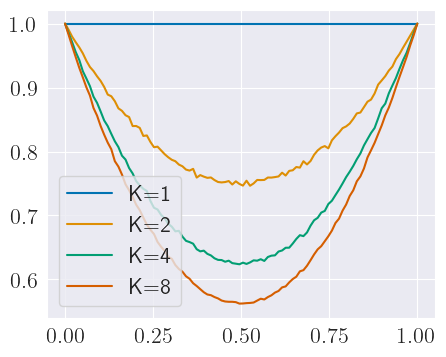

In [100]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

for k in Ks:
    plt.plot(ps, ys[k], label=f"K={k}")

#plt.xlabel(r'$p$')
#plt.ylabel(r'$\mathbb{E}[f(\hat{p}_K)]$')
plt.grid()
plt.legend() #(loc=1)

plt.show()